# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [31]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector
from fad.models.NNs import MLP_wrapper

In [32]:
import hls4ml

## 1. Data Loading and Exploration

In [33]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3500000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

path_anom3 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/hToTauTau_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset3 = _load_h5_challenge_dataset(
    path_bkg, path_anom3, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset3.train.shape}")
print(f"Test set shape: {dataset3.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset3.test_labels)}")

path_anom4 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/hChToTauNu_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset4 = _load_h5_challenge_dataset(
    path_bkg, path_anom4, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset4.train.shape}")
print(f"Test set shape: {dataset4.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset4.test_labels)}")


Loading datasets...
Discarding type index, shape bkg: (3560000, 19, 3), shape anom: (55969, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (115969, 57)
Number of anomalies in test set: 55969.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (340544, 19, 3)
Training set shape: (100000, 57)
Test set shape: (740544, 57)
Number of anomalies in test set: 340544.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (400000, 19, 3)
Training set shape: (100000, 57)
Test set shape: (800000, 57)
Number of anomalies in test set: 400000.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (400000, 19, 3)
Training set shape: (100000, 57)
Test set shape: (800000, 57)
Number of anomalies in test set: 400000.0


## 2. Data Preprocessing

In [34]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)
X_test3 = preprocessor.transform(dataset3.test)
X_test4 = preprocessor.transform(dataset4.test)

Preprocessing data...


Done


## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [35]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [36]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

# for dataset2
iso_scores2 = iso_forest.predict(X_test2)
iso_auc2 = roc_auc_score(dataset2.test_labels, iso_scores2)
iso_ap2 = average_precision_score(dataset2.test_labels, iso_scores2)
iso_accuracy2 = accuracy_score(dataset2.test_labels, iso_scores2 < 0)
print(f"Accuracy: {iso_accuracy2:.4f}")
print(f"AUC-ROC: {iso_auc2:.4f}")
print(f"Average Precision: {iso_ap2:.4f}")


results["Isolation Forest"] = {
    "scores": iso_scores,
    "auc": iso_auc,
    "ap": iso_ap,
    "time": iso_time,
}

Training Isolation Forest...
Training time: 13.06 seconds
Accuracy: 0.4260
AUC-ROC: 0.8667
Average Precision: 0.8425
Accuracy: 0.4141
AUC-ROC: 0.8434
Average Precision: 0.7979


In [37]:
print(X_train.shape[1])

57


### 4.2 Flow Matching

In [38]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
# flow_matching  = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.load("flow_matching_model.pt")

print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.fit(X_train, mode="OT", reflow=False)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")

Training Flow Matching (this may take a while)...
| iter      1 | 10273.79 ms/step | loss    1.218 
| iter      2 | 17401.81 ms/step | loss    1.202 
| iter      3 | 14719.15 ms/step | loss    1.165 
| iter      4 | 10907.83 ms/step | loss    1.146 
| iter      5 | 14043.80 ms/step | loss    1.145 
| iter      6 | 11400.43 ms/step | loss    1.156 
| iter      7 | 5941.05 ms/step | loss    1.146 
| iter      8 | 8648.20 ms/step | loss    1.180 
| iter      9 | 9769.08 ms/step | loss    1.153 
| iter     10 | 12039.58 ms/step | loss    1.138 
| iter     11 | 8280.82 ms/step | loss    1.190 
| iter     12 | 14641.10 ms/step | loss    1.152 
| iter     13 | 11312.47 ms/step | loss    1.132 
| iter     14 | 13842.80 ms/step | loss    1.169 
| iter     15 | 10233.69 ms/step | loss    1.139 
| iter     16 | 10244.54 ms/step | loss    1.128 
| iter     17 | 9807.99 ms/step | loss    1.144 
| iter     18 | 12599.42 ms/step | loss    1.145 
| iter     19 | 15179.32 ms/step | loss    1.122 
| ite

In [39]:
# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# now again in ODE mode
flow_scores, transformed_data = flow_matching.predict(
    X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 1000)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
results["Flow Matching ode"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

Mean score for normal samples: 2.1448
Std score for normal samples: 6.8181
Mean score for anomalous samples: 73.3330
Std score for anomalous samples: 187.3040
Accuracy: 0.7192
AUC-ROC: 0.8653
Average Precision: 0.8725
time grid: tensor([1., 0.])
Mean score for normal samples: 68.4620
Std score for normal samples: 782.5504
Mean score for anomalous samples: 7010.1641
Std score for anomalous samples: 41881.3086
Accuracy: 0.5670
AUC-ROC: 0.8746
Average Precision: 0.8786


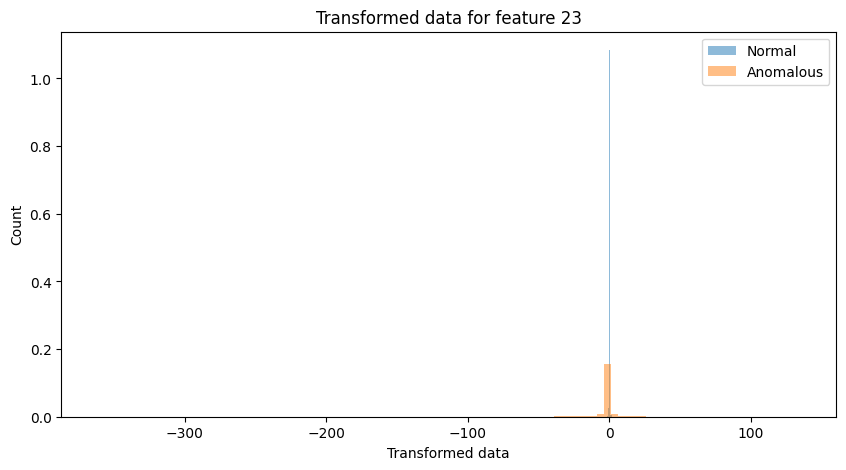

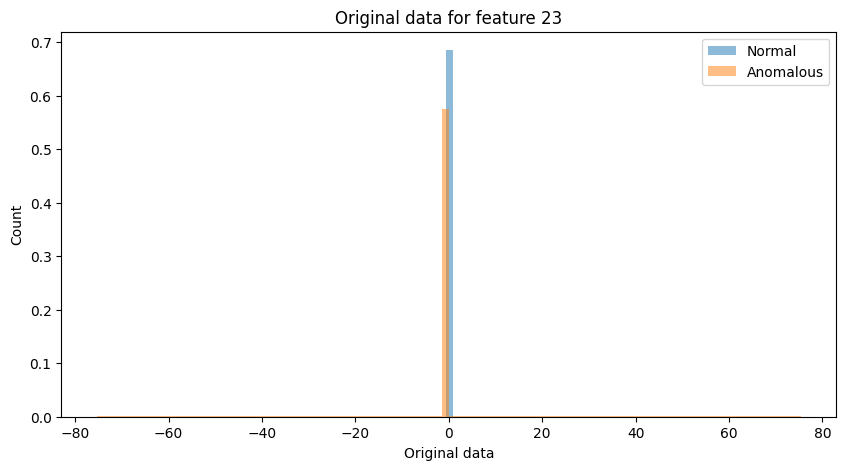

In [40]:
# plot an histogram of transformed data for one of the features
n_feature = 23
plt.figure(figsize=(10, 5))
plt.hist(
    transformed_data[dataset.test_labels == 0][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Normal",
    density=True,
)
plt.hist(
    transformed_data[dataset.test_labels == 1][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Anomalous",
    density=True,
)
plt.xlabel("Transformed data")
plt.ylabel("Count")
plt.title(f"Transformed data for feature {n_feature}")
plt.legend()
plt.show()

# now for the original dataset X_test
plt.figure(figsize=(10, 5))
plt.hist(
    X_test[dataset.test_labels == 0][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Normal",
    density=True,
)
plt.hist(
    X_test[dataset.test_labels == 1][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Anomalous",
    density=True,
)
plt.xlabel("Original data")
plt.ylabel("Count")
plt.title(f"Original data for feature {n_feature}")
plt.legend()
plt.show()

In [41]:
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}
# now again in ODE mode
flow_scores2 = flow_matching.predict(
    X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 100)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
results["Flow Matching2 ode"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

Mean score for normal samples: 2.1928
Std score for normal samples: 7.8936
Mean score for anomalous samples: 10.5805
Std score for anomalous samples: 28.7900
Accuracy: 0.6285
AUC-ROC: 0.7919
Average Precision: 0.7577
time grid: tensor([1., 0.])


Mean score for normal samples: 36.5509
Std score for normal samples: 551.2690
Mean score for anomalous samples: 207.4159
Std score for anomalous samples: 3626.8184
Accuracy: 0.6245
AUC-ROC: 0.7931
Average Precision: 0.7609


In [42]:
# Predict anomaly scores
flow_scores3 = flow_matching.predict(X_test3, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")

results["Flow Matching3 vt"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "time": 1,
}
# now again in ODE mode
flow_scores3 = flow_matching.predict(
    X_test3, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 100)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")
results["Flow Matching3 ode"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "time": 1,
}

Mean score for normal samples: 2.1928
Std score for normal samples: 7.8936
Mean score for anomalous samples: 10.1065
Std score for anomalous samples: 35.6892
Accuracy: 0.5689
AUC-ROC: 0.6715
Average Precision: 0.6928
time grid: tensor([1., 0.])
Mean score for normal samples: 36.5341
Std score for normal samples: 551.2759
Mean score for anomalous samples: 261.9046
Std score for anomalous samples: 4650.7817
Accuracy: 0.5689
AUC-ROC: 0.6858
Average Precision: 0.7038


In [43]:
# Predict anomaly scores
flow_scores4 = flow_matching.predict(X_test4, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")

results["Flow Matching4 vt"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "time": 1,
}
# now again in ODE mode
flow_scores4 = flow_matching.predict(
    X_test4, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 100)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")
results["Flow Matching4 ode"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "time": 1,
}

Mean score for normal samples: 2.1928
Std score for normal samples: 7.8936
Mean score for anomalous samples: 13.5892
Std score for anomalous samples: 31.6768


Accuracy: 0.6480
AUC-ROC: 0.8477
Average Precision: 0.8370
time grid: tensor([1., 0.])
Mean score for normal samples: 36.5458
Std score for normal samples: 551.2886
Mean score for anomalous samples: 245.9326
Std score for anomalous samples: 3761.2139
Accuracy: 0.6453
AUC-ROC: 0.8555
Average Precision: 0.8493


## 5. Model Comparison and Visualization

Isolation Forest
Flow Matching vt
Flow Matching ode
Flow Matching2 vt
Flow Matching2 ode
Flow Matching3 vt
Flow Matching3 ode
Flow Matching4 vt
Flow Matching4 ode


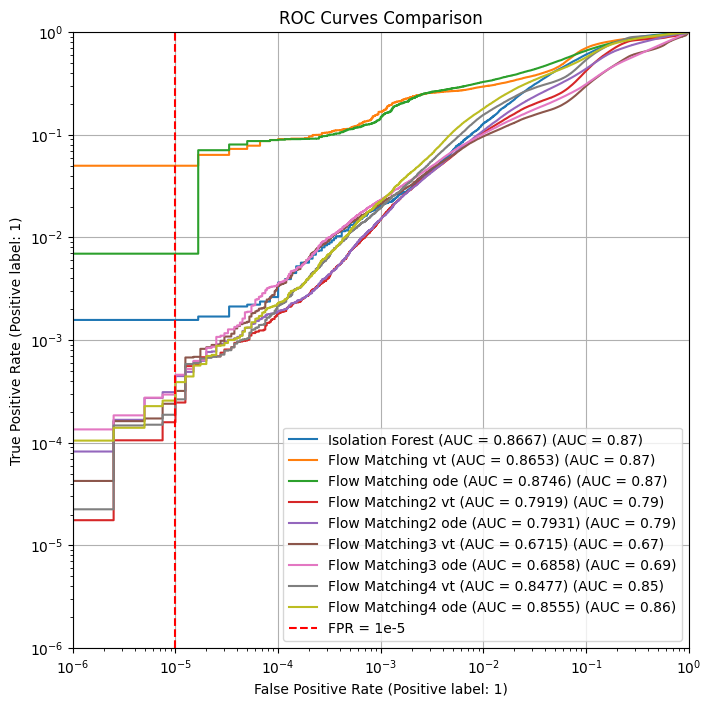

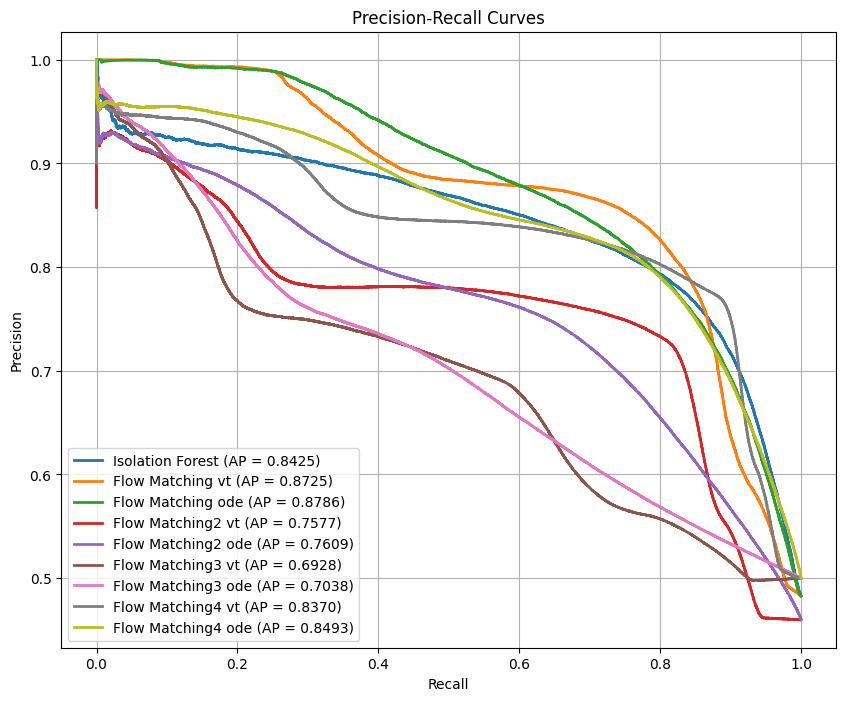

In [44]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 ode"):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name == "Flow Matching3 vt") | (name == "Flow Matching3 ode"):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name == "Flow Matching4 vt") | (name == "Flow Matching4 ode"):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 ode"):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name == "Flow Matching3 vt") | (name == "Flow Matching3 ode"):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name == "Flow Matching4 vt") | (name == "Flow Matching4 ode"):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

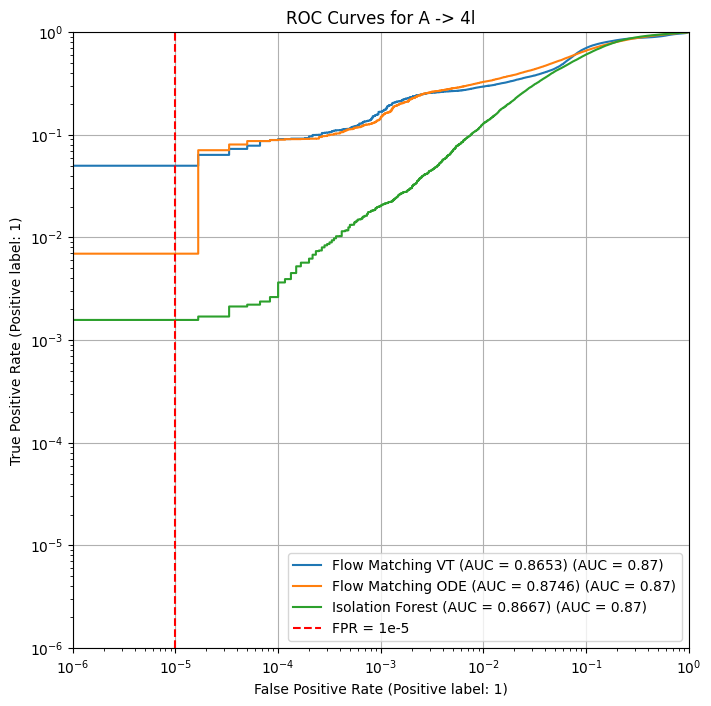

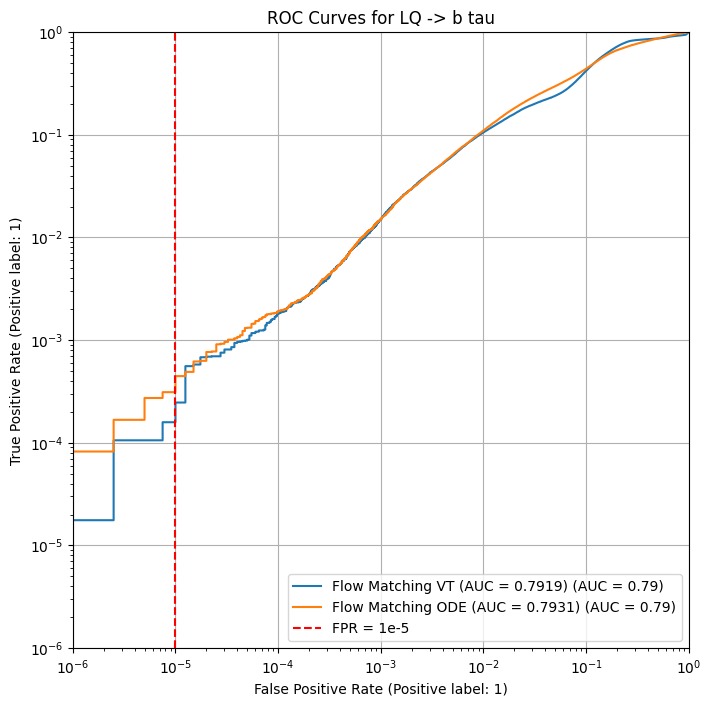

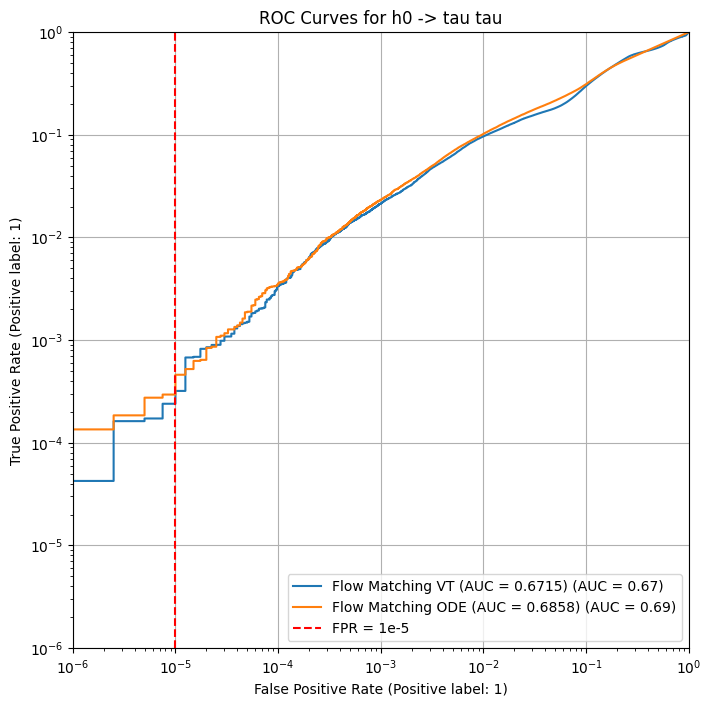

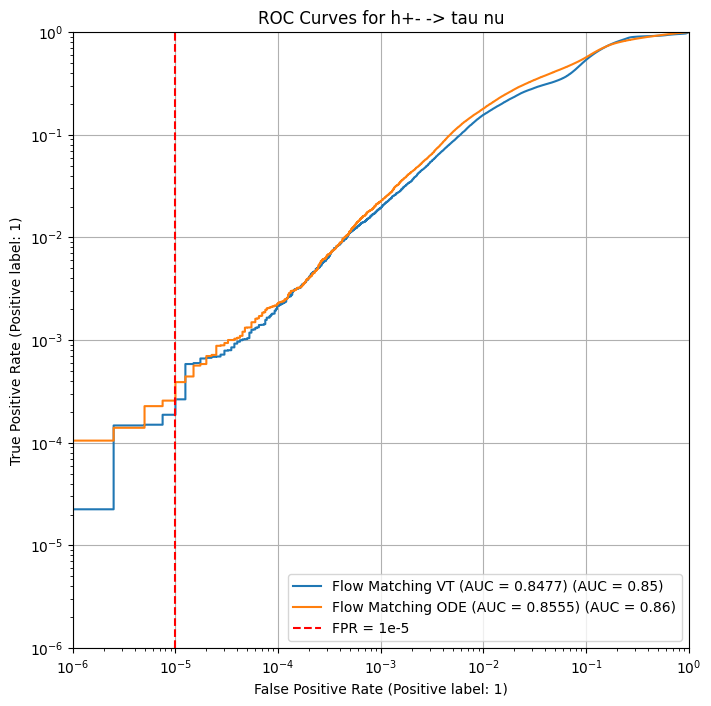

In [45]:
# Define dataset names and corresponding results prefixes/labels
dataset_info = [
    {"name": "A -> 4l", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt", "suffix_ode": "ode"},
    {"name": "LQ -> b tau", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt", "suffix_ode": "ode"},
    {"name": "h0 -> tau tau", "prefix": "Flow Matching3 ", "labels": dataset3.test_labels, "suffix_vt": "vt", "suffix_ode": "ode"},
    {"name": "h+- -> tau nu", "prefix": "Flow Matching4 ", "labels": dataset4.test_labels, "suffix_vt": "vt", "suffix_ode": "ode"},
    # Add entries for models trained with type index if they exist and need plotting
    # {"name": "A -> 4l (with type idx)", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt with type idx", "suffix_ode": "ode with type idx"},
    # {"name": "LQ -> b tau (with type idx)", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt with type idx", "suffix_ode": "ode with type idx"},
]

for info in dataset_info:
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    dataset_name = info["name"]
    prefix = info["prefix"]
    labels = info["labels"]
    
    # Plot vt mode
    vt_key = prefix + info["suffix_vt"]
    if vt_key in results:
        result_vt = results[vt_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vt["scores"],
            name=f"Flow Matching VT (AUC = {result_vt['auc']:.4f})",
            ax=ax,
        )
    
    # Plot ode mode
    ode_key = prefix + info["suffix_ode"]
    if ode_key in results:
        result_ode = results[ode_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_ode["scores"],
            name=f"Flow Matching ODE (AUC = {result_ode['auc']:.4f})",
            ax=ax,
        )
        
    # Add Isolation Forest for the first dataset for comparison
    if dataset_name == "A -> 4l" and "Isolation Forest" in results:
         result_iso = results["Isolation Forest"]
         RocCurveDisplay.from_predictions(
             labels,
             result_iso["scores"],
             name=f"Isolation Forest (AUC = {result_iso['auc']:.4f})",
             ax=ax,
         )

    plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([1e-6, 1])
    plt.ylim([1e-6, 1])
    plt.title(f"ROC Curves for {dataset_name}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison (All Models)") # Updated title
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (All Models)") # Updated title
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

In [13]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    if name != "Flow Matching":
        continue
    plt.subplot(1, 1, 1)

    # Separate scores for normal and anomaly classes
    if name == "Flow Matching2":
        # use the second dataset for this model
        normal_scores = result["scores"][dataset2.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset2.test_labels == 1]
    else:
        normal_scores = result["scores"][dataset.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

torch.Size([2, 5, 57])
torch.Size([2, 5, 57])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

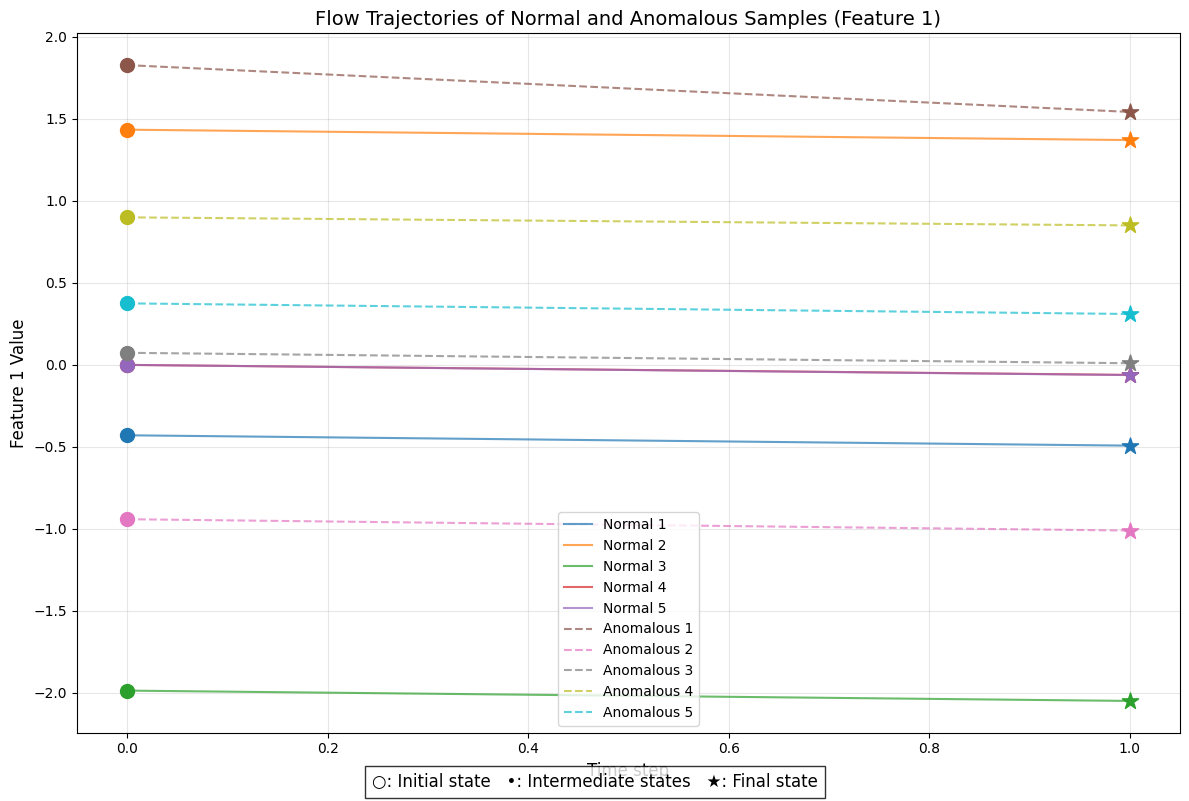

In [14]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i + 1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i}",
        s=150,
        zorder=10,
    )

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(
        trajectory[:, 4],
        label=f"Anomalous {i + 1}",
        linestyle="--",
        color=f"C{i + 5}",
        alpha=0.7,
    )
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i + 5}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i + 5}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i + 5}",
        s=150,
        zorder=10,
    )

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(
    0.5,
    0.01,
    "○: Initial state   •: Intermediate states   ★: Final state",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

## 7. Results Summary

In [15]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8689     0.8430          11.62          
Flow Matching vt     0.8575     0.8643          1.00           
Flow Matching ode    0.8803     0.8841          1.00           
Flow Matching2 vt    0.7913     0.7621          1.00           
Flow Matching2 ode   0.7899     0.7595          1.00           


In [16]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3500000, n_test=60000, discard_type_idx=False)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=400000, discard_type_idx=False
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

Loading datasets...
Training set shape: (3500000, 76)
Test set shape: (115969, 76)
Number of anomalies in test set: 55969.0
Loading datasets...
Training set shape: (100000, 76)
Test set shape: (740544, 76)
Number of anomalies in test set: 340544.0


In [17]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)

Preprocessing data...
Done


In [18]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
# flow_matching  = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.load("flow_matching_model.pt")

print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.fit(X_train, mode="OT", reflow=False)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")

Training Flow Matching (this may take a while)...
| iter      1 | 24074.20 ms/step | loss    1.240 
| iter      2 | 17158.89 ms/step | loss    1.207 
| iter      3 | 16708.90 ms/step | loss    1.238 
| iter      4 | 21654.02 ms/step | loss    1.202 
| iter      5 | 15386.71 ms/step | loss    1.214 
Training time: 95.30 seconds


In [19]:
# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt with type idx"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# now again in ODE mode
flow_scores, transformed_data = flow_matching.predict(
    X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
results["Flow Matching ode with type idx"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

Mean score for normal samples: 4.2258
Std score for normal samples: 6.6523
Mean score for anomalous samples: 63.8534
Std score for anomalous samples: 134.7336
Accuracy: 0.7751
AUC-ROC: 0.8513
Average Precision: 0.8733
time grid: tensor([1., 0.])
Mean score for normal samples: 89.3331
Std score for normal samples: 892.9461
Mean score for anomalous samples: 8008.4399
Std score for anomalous samples: 39312.0625
Accuracy: 0.4826
AUC-ROC: 0.8942
Average Precision: 0.8956


In [20]:
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt with type idx"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}
# now again in ODE mode
flow_scores2 = flow_matching.predict(
    X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
results["Flow Matching2 ode with type idx"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

Mean score for normal samples: 4.2672
Std score for normal samples: 7.4291
Mean score for anomalous samples: 12.8378
Std score for anomalous samples: 25.8525
Accuracy: 0.6596
AUC-ROC: 0.7637
Average Precision: 0.7508
time grid: tensor([1., 0.])
Mean score for normal samples: 62.3997
Std score for normal samples: 590.0229
Mean score for anomalous samples: 291.9750
Std score for anomalous samples: 3986.1611
Accuracy: 0.4599
AUC-ROC: 0.8036
Average Precision: 0.7746


In [ ]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison (All Models)") # Updated title
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name.startswith("Flow Matching2 vt")) | (name.startswith("Flow Matching2 ode")):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching3 vt")) | (name.startswith("Flow Matching3 ode")):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name.startswith("Flow Matching4 vt")) | (name.startswith("Flow Matching4 ode")):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (All Models)") # Updated title
plt.legend()
plt.grid(True)
plt.show()